In [ ]:
import os

import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import random

import hickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from btksims.utils import get_btksims_config_path
from maddeb.extraction import extract_cutouts
from maddeb.FlowVAEnet import FlowVAEnet
from maddeb.utils import get_data_dir_path, get_maddeb_config_path

%matplotlib inline

In [ ]:
with open(get_btksims_config_path()) as f:
    btksims_config = yaml.safe_load(f)

with open(get_maddeb_config_path()) as f:
    maddeb_config = yaml.safe_load(f)

## Simulation (train/validation set) examples

In [ ]:
blended_images_dir = os.path.join(
    btksims_config["TRAIN_DATA_SAVE_PATH"], "blended_training"
)

In [ ]:
filename = random.choice(os.listdir(blended_images_dir))

In [ ]:
linear_norm_coeff = 10000

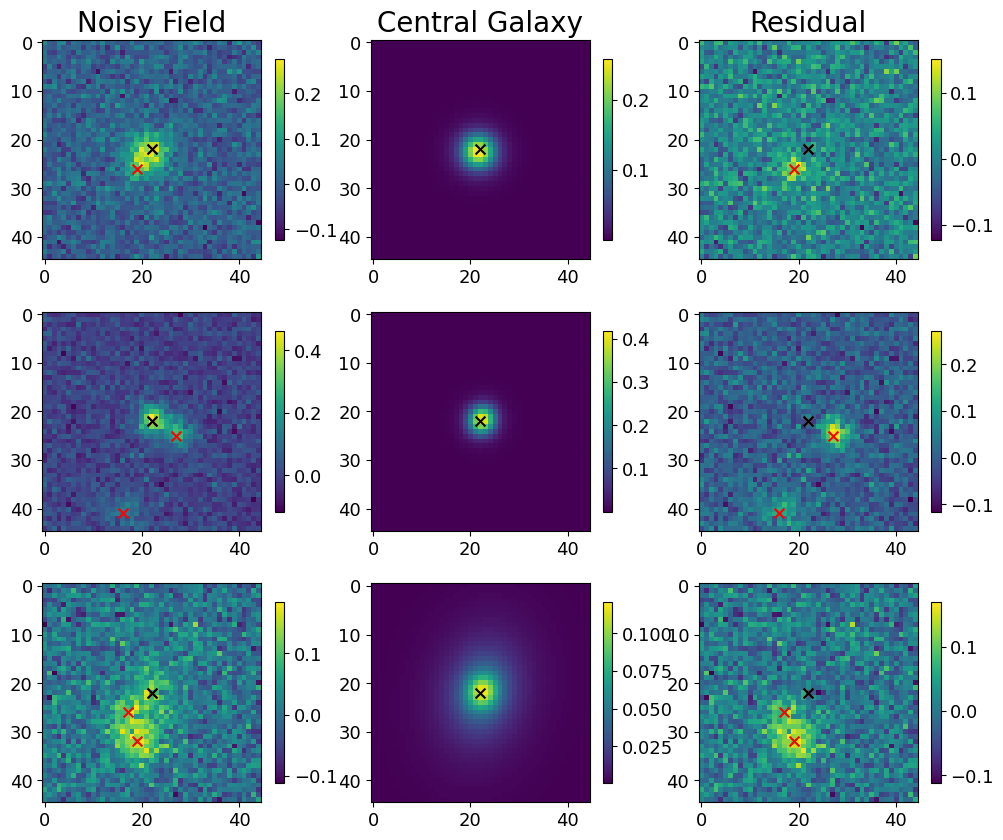

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

rng = np.random.default_rng(seed=13)

band = 2

for i in range(3):
    filename = random.choice(os.listdir(blended_images_dir))
    blended_images = np.load(
        os.path.join(blended_images_dir, filename), allow_pickle=True
    )
    im = axs[i, 0].imshow(
        blended_images["blended_gal_stamps"][0][:, :, band] / linear_norm_coeff
    )
    cbar = fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    im = axs[i, 1].imshow(
        blended_images["isolated_gal_stamps"][0][:, :, band] / linear_norm_coeff
    )
    cbar = fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    difference = (
        blended_images["blended_gal_stamps"][0][:, :, band]
        - blended_images["isolated_gal_stamps"][0][:, :, band]
    )
    im = axs[i, 2].imshow(difference / linear_norm_coeff)
    cbar = fig.colorbar(im, ax=axs[i, 2], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    for num_gal in range(len(blended_images["gal_locations_x_peak"][0])):

        axs[i, 0].scatter(
            np.round(blended_images["gal_locations_x_peak"][0][num_gal]) + 22,
            np.round(blended_images["gal_locations_y_peak"][0][num_gal]) + 22,
            c="r",
            marker="x",
            s=50,
        )

        axs[i, 2].scatter(
            np.round(blended_images["gal_locations_x_peak"][0][num_gal]) + 22,
            np.round(blended_images["gal_locations_y_peak"][0][num_gal]) + 22,
            c="r",
            marker="x",
            s=50,
        )

    for col_num in range(3):
        axs[i, col_num].scatter(22, 22, c="black", marker="x", s=50)
        axs[i, col_num].tick_params(axis="both", which="major", labelsize=13)


axs[0, 0].set_title("Noisy Field", fontsize=20)
axs[0, 1].set_title("Central Galaxy", fontsize=20)
axs[0, 2].set_title("Residual", fontsize=20)
plt.savefig("results/blended_galaxies")
plt.savefig("results/blended_galaxies.pdf", bbox_inches="tight")

# Make plots for isolated galaxies

In [ ]:
isolated_images_dir = os.path.join(
    btksims_config["TRAIN_DATA_SAVE_PATH"], "isolated_training"
)

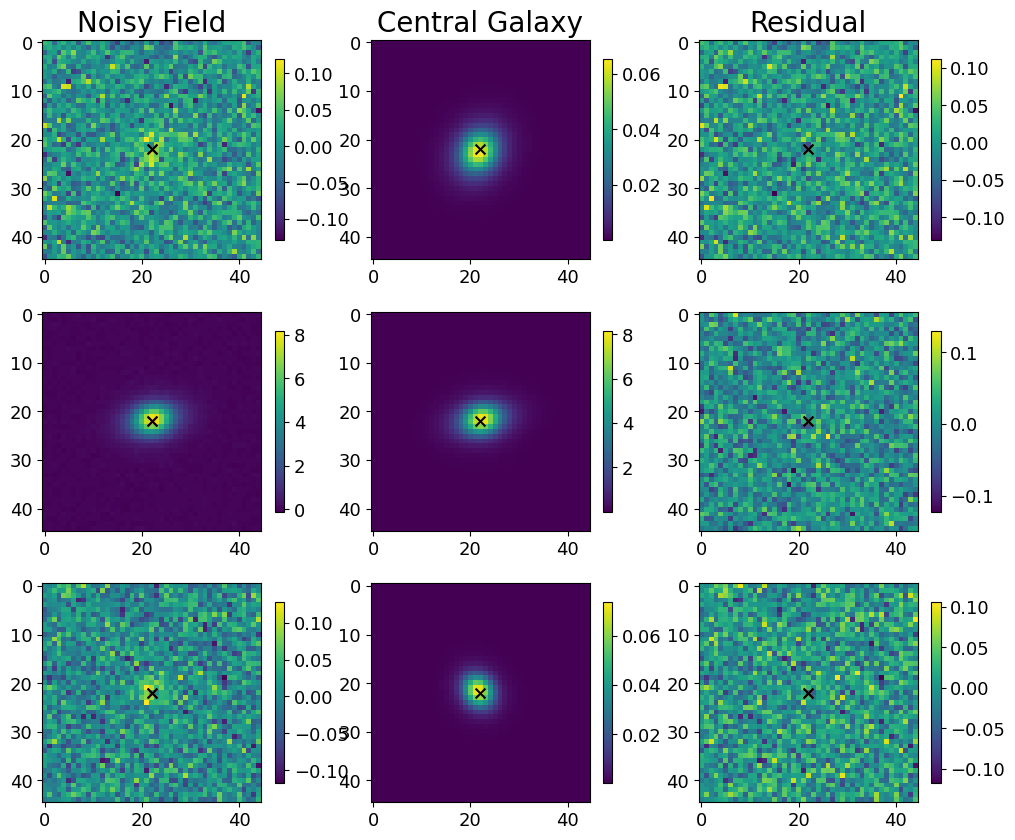

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

rng = np.random.default_rng(seed=5)

band = 2

for i in range(3):
    filename = random.choice(os.listdir(isolated_images_dir))
    blended_images = np.load(
        os.path.join(isolated_images_dir, filename), allow_pickle=True
    )
    im = axs[i, 0].imshow(
        blended_images["blended_gal_stamps"][0][:, :, band] / linear_norm_coeff
    )
    cbar = fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    im = axs[i, 1].imshow(
        blended_images["isolated_gal_stamps"][0][:, :, band] / linear_norm_coeff
    )
    cbar = fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    difference = (
        blended_images["blended_gal_stamps"][0][:, :, band]
        - blended_images["isolated_gal_stamps"][0][:, :, band]
    )
    im = axs[i, 2].imshow(difference / linear_norm_coeff)
    cbar = fig.colorbar(im, ax=axs[i, 2], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    for num_gal in range(len(blended_images["gal_locations_x_peak"][0])):

        axs[i, 0].scatter(
            np.round(blended_images["gal_locations_x_peak"][0][num_gal]) + 22,
            np.round(blended_images["gal_locations_y_peak"][0][num_gal]) + 22,
            c="r",
            marker="x",
            s=50,
        )

        axs[i, 2].scatter(
            np.round(blended_images["gal_locations_x_peak"][0][num_gal]) + 22,
            np.round(blended_images["gal_locations_y_peak"][0][num_gal]) + 22,
            c="r",
            marker="x",
            s=50,
        )

    for col_num in range(3):
        axs[i, col_num].scatter(22, 22, c="black", marker="x", s=50)
        axs[i, col_num].tick_params(axis="both", which="major", labelsize=13)


axs[0, 0].set_title("Noisy Field", fontsize=20)
axs[0, 1].set_title("Central Galaxy", fontsize=20)
axs[0, 2].set_title("Residual", fontsize=20)
plt.savefig("results/isolated_galaxies")
plt.savefig("results/isolated_galaxies.pdf", bbox_inches="tight")

In [ ]:
data_dir = get_data_dir_path()

tf.get_logger().setLevel("ERROR")
latent_dim = 16
num_nf_layers = 6
kl_weight = 1

model_path = os.path.join(data_dir, "LSST/")

flow_net = FlowVAEnet(latent_dim=latent_dim, num_nf_layers=num_nf_layers)

flow_net.load_flow_weights(weights_path=os.path.join(model_path, "flow/val_loss"))
flow_net.load_vae_weights(weights_path=os.path.join(model_path, "vae/val_loss"))
flow_net.load_encoder_weights(
    weights_path=os.path.join(model_path, "deblender/val_loss")
)
flow_net.vae_model.trainable = False
print(flow_net.vae_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 45, 45, 6)]       0         
                                                                 
 encoder (Functional)        (None, 152)               6696216   
                                                                 
 latent_space (MultivariateN  ((None, 16),             0         
 ormalTriL)                   (None, 16))                        
                                                                 
 decoder (Functional)        (None, 45, 45, 6)         3657446   
                                                                 
Total params: 10,353,662
Trainable params: 0
Non-trainable params: 10,353,662
_________________________________________________________________
None


In [ ]:
flow_net.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_2 (Dense)             (None, 512)               8704      
                                                                 
 p_re_lu_6 (PReLU)           (None, 512)               512       
                                                                 
 tf.cast (TFOpLambda)        (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4608)              2363904   
                                                                 
 p_re_lu_7 (PReLU)           (None, 4608)              4608      
                                                                 
 reshape (Reshape)           (None, 6, 6, 128)         0   

In [ ]:
tf.get_logger().setLevel("ERROR")
model_vae_output_isolated = flow_net.vae_model(
    np.array(list(blended_images["blended_gal_stamps"])) / linear_norm_coeff
)

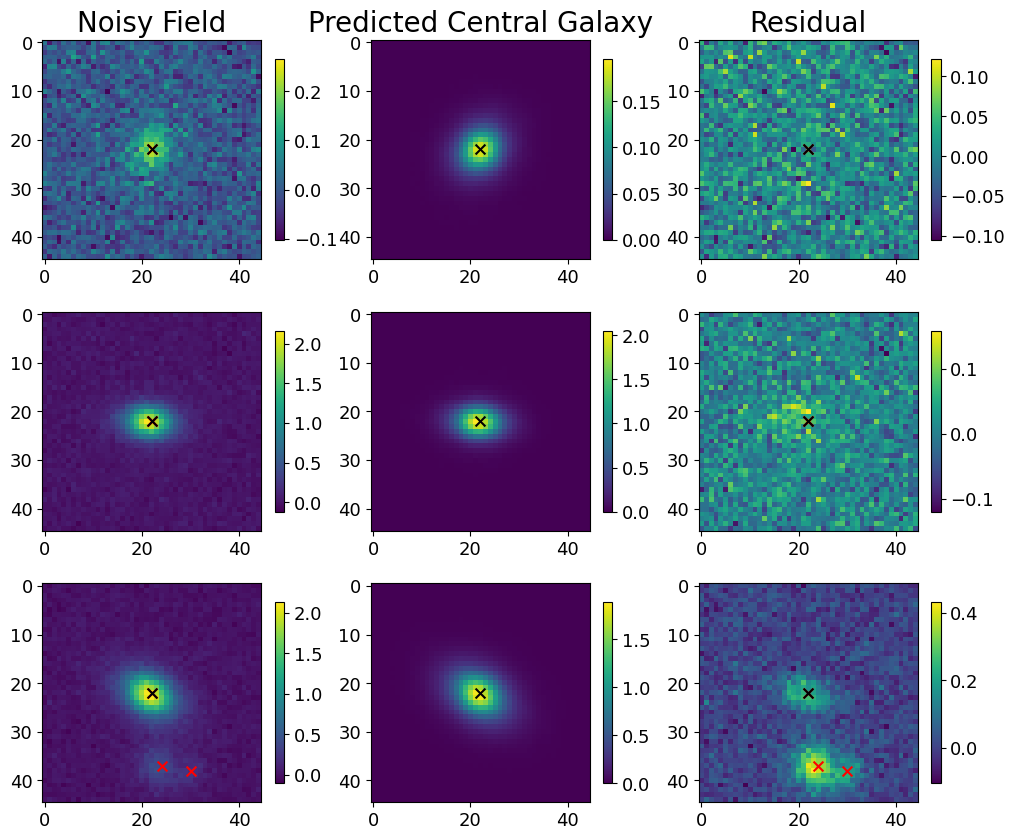

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

rng = np.random.default_rng(seed=13)

band = 2

for i in range(3):
    filename = random.choice(os.listdir(blended_images_dir))
    blended_images = np.load(
        os.path.join(blended_images_dir, filename), allow_pickle=True
    )

    model_vae_output_isolated = flow_net.vae_model(
        np.array(list(blended_images["blended_gal_stamps"])) / linear_norm_coeff
    )

    im = axs[i, 0].imshow(
        blended_images["blended_gal_stamps"][0][:, :, band] / linear_norm_coeff
    )
    cbar = fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    im = axs[i, 1].imshow(model_vae_output_isolated[0][:, :, band])
    cbar = fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    difference = (
        blended_images["blended_gal_stamps"][0][:, :, band] / linear_norm_coeff
        - model_vae_output_isolated[0][:, :, band]
    )
    im = axs[i, 2].imshow(difference)
    cbar = fig.colorbar(im, ax=axs[i, 2], shrink=0.8)
    cbar.ax.tick_params(labelsize=13)

    for num_gal in range(len(blended_images["gal_locations_x_peak"][0])):

        axs[i, 0].scatter(
            np.round(blended_images["gal_locations_x_peak"][0][num_gal]) + 22,
            np.round(blended_images["gal_locations_y_peak"][0][num_gal]) + 22,
            c="r",
            marker="x",
            s=50,
        )

        axs[i, 2].scatter(
            np.round(blended_images["gal_locations_x_peak"][0][num_gal]) + 22,
            np.round(blended_images["gal_locations_y_peak"][0][num_gal]) + 22,
            c="r",
            marker="x",
            s=50,
        )

    for col_num in range(3):
        axs[i, col_num].scatter(22, 22, c="black", marker="x", s=50)
        axs[i, col_num].tick_params(axis="both", which="major", labelsize=13)


axs[0, 0].set_title("Noisy Field", fontsize=20)
axs[0, 1].set_title("Predicted Central Galaxy", fontsize=20)
axs[0, 2].set_title("Residual", fontsize=20)
plt.savefig("results/VAEDeblender")
plt.savefig("results/VAEDeblender.pdf", bbox_inches="tight")

# Blendedness variation

In [ ]:
data_path = os.path.join(maddeb_config["RESULTS_PATH"], "high_density")
run_name = "kl1"  # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
madness_results = []
scarlet_results = []
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")
        )
    )
    # scarlet_results.append(pd.read_pickle(os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")))

    # actual_photometry.append(pd.read_pickle(os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")))
    # blended_photometry.append(pd.read_pickle(os.path.join(data_path, "blended_photometry",  str(file_num) + ".pkl")))

madness_results = pd.concat(madness_results)
# scarlet_results = pd.concat(scarlet_results)

# actual_photometry = pd.concat(actual_photometry)
# blended_photometry = pd.concat(blended_photometry)

In [ ]:
madness_results.columns

Index(['u_cosd', 'u_ssim', 'u_blendedness', 'g_cosd', 'g_ssim',
       'g_blendedness', 'r_cosd', 'r_ssim', 'r_blendedness', 'i_cosd',
       'i_ssim', 'i_blendedness', 'z_cosd', 'z_ssim', 'z_blendedness',
       'y_cosd', 'y_ssim', 'y_blendedness', 'galaxy_num', 'size', 'field_num',
       'file_num', 'r_band_snr', 'ref_mag', 'u_ab', 'g_ab', 'r_ab', 'i_ab',
       'z_ab', 'y_ab', 'u_phot_flux', 'u_phot_fluxerrs', 'u_phot_flags',
       'g_phot_flux', 'g_phot_fluxerrs', 'g_phot_flags', 'r_phot_flux',
       'r_phot_fluxerrs', 'r_phot_flags', 'i_phot_flux', 'i_phot_fluxerrs',
       'i_phot_flags', 'z_phot_flux', 'z_phot_fluxerrs', 'z_phot_flags',
       'y_phot_flux', 'y_phot_fluxerrs', 'y_phot_flags', 'r_contamination'],
      dtype='object')

In [ ]:
simulation_path = os.path.join(maddeb_config["TEST_DATA_PATH"], "high")

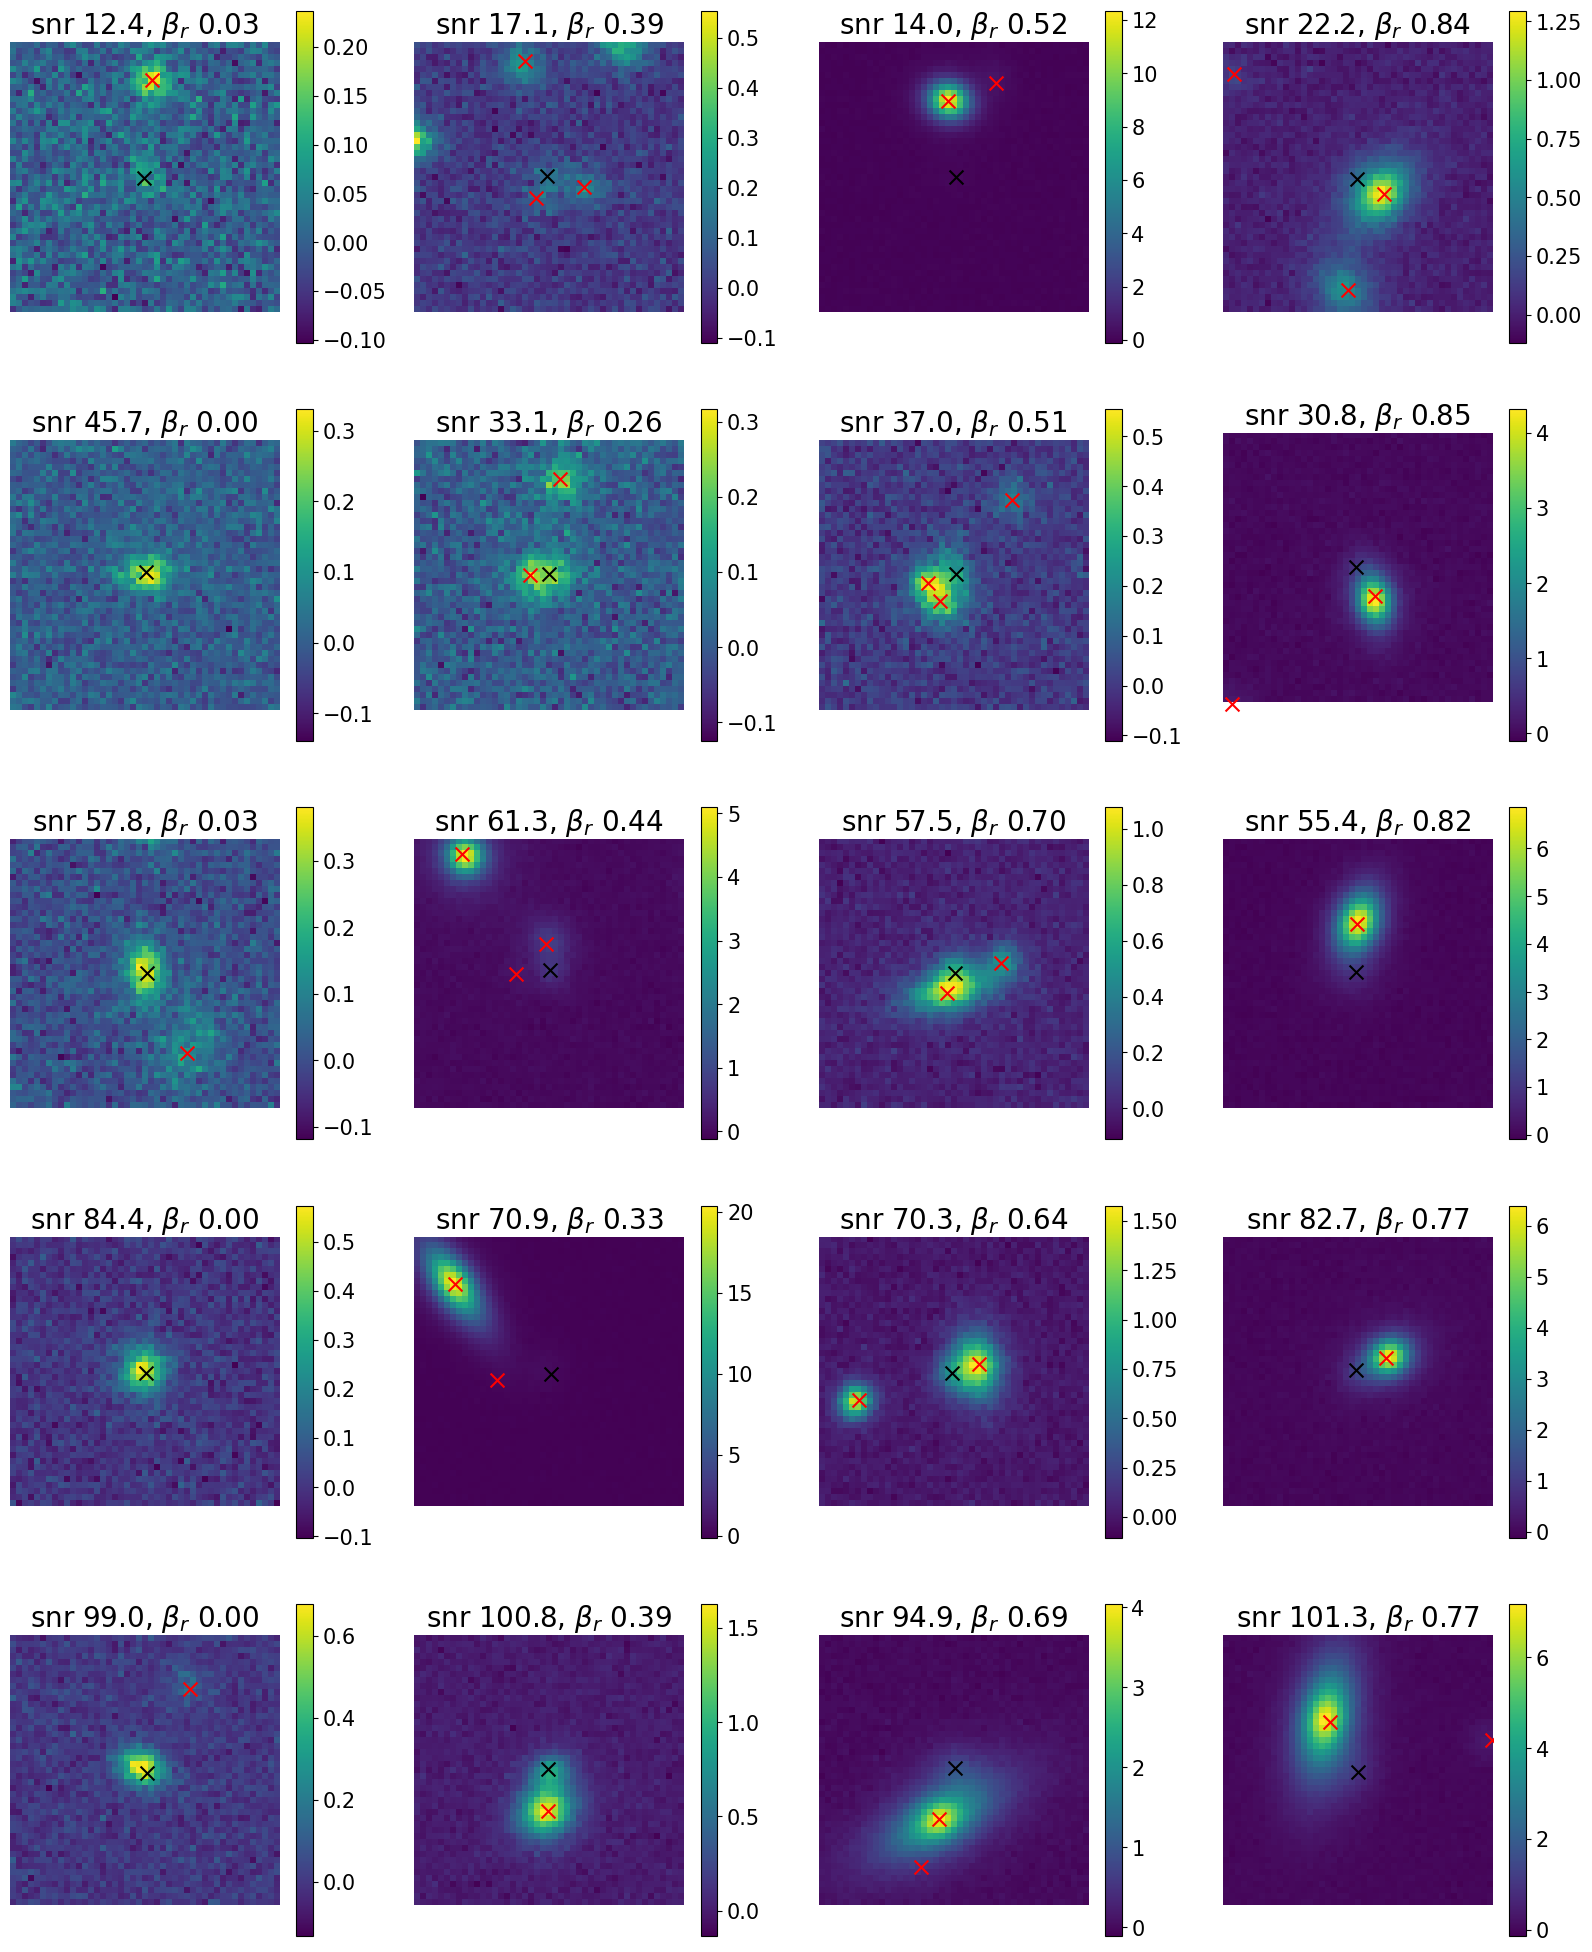

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(4 * 5, 5 * 5))
for snr_num, snr in enumerate(range(10, 110, 20)):
    # print(snr)
    mask = (madness_results["r_band_snr"] > snr) & (
        madness_results["r_band_snr"] < (snr + 20)
    )
    snr_cut = madness_results[mask]
    for blendedness_num, blendedness in enumerate(np.arange(0, 1, 0.25)):
        # print(blendedness)
        mask2 = (snr_cut["r_blendedness"] > blendedness) & (
            snr_cut["r_blendedness"] < (blendedness + 0.2)
        )
        blendedness_cut = snr_cut[mask2]

        row = blendedness_cut.sample(random_state=17)

        file_num = row["file_num"].values[0]
        field_num = row["field_num"].values[0]
        galaxy_num = row["galaxy_num"].values[0]

        # print(row['file_num'].values[0])
        blend = hickle.load(
            os.path.join(
                simulation_path,
                str(file_num) + ".hkl",
            )
        )

        x_pos = blend["blend_list"][field_num]["y_peak"][galaxy_num]
        y_pos = blend["blend_list"][field_num]["x_peak"][galaxy_num]

        gal_blended = extract_cutouts(
            blend["blend_images"][field_num],
            [(x_pos, y_pos)],
            distances_to_center=False,
            channel_last=False,
            cutout_size=45,
        )[0][0]

        # print(np.shape(gal_blended))

        im1 = ax[snr_num, blendedness_num].imshow(gal_blended[:, :, 2] / 10000)
        cbar = fig.colorbar(im1, ax=ax[snr_num, blendedness_num])
        cbar.ax.tick_params(labelsize=15)
        ax[snr_num, blendedness_num].set_title(
            r"snr {:.1f}, $\beta_r$ {:.2f}".format(
                row["r_band_snr"].values[0], row["r_blendedness"].values[0]
            ),
            fontsize=20,
        )
        # ax[snr_num, blendedness_num].scatter(22, 22, c="r", marker="x")
        ax[snr_num, blendedness_num].axis("off")
        for current_galaxy in range(len(blend["blend_list"][field_num]["x_peak"])):

            if current_galaxy == galaxy_num:
                continue

            y_loc = (
                np.round(blend["blend_list"][field_num]["y_peak"][current_galaxy])
                + 22
                - x_pos
            )
            x_loc = (
                np.round(blend["blend_list"][field_num]["x_peak"][current_galaxy])
                + 22
                - y_pos
            )

            if ((x_loc > 0) & (x_loc < 45)) & ((y_loc > 0) & (y_loc < 45)):

                ax[snr_num, blendedness_num].scatter(
                    x_loc, y_loc, c="r", marker="x", s=100
                )

        # print(blendedness_cut)
        ax[snr_num, blendedness_num].scatter(
            np.round(blend["blend_list"][field_num]["y_peak"][galaxy_num]) + 22 - x_pos,
            np.round(blend["blend_list"][field_num]["x_peak"][galaxy_num]) + 22 - y_pos,
            c="black",
            marker="x",
            s=100,
        )

plt.savefig("results/blendedness_variation_plot.pdf")
plt.savefig("results/blendedness_variation_plot.png")

# Scarlet Comparisons

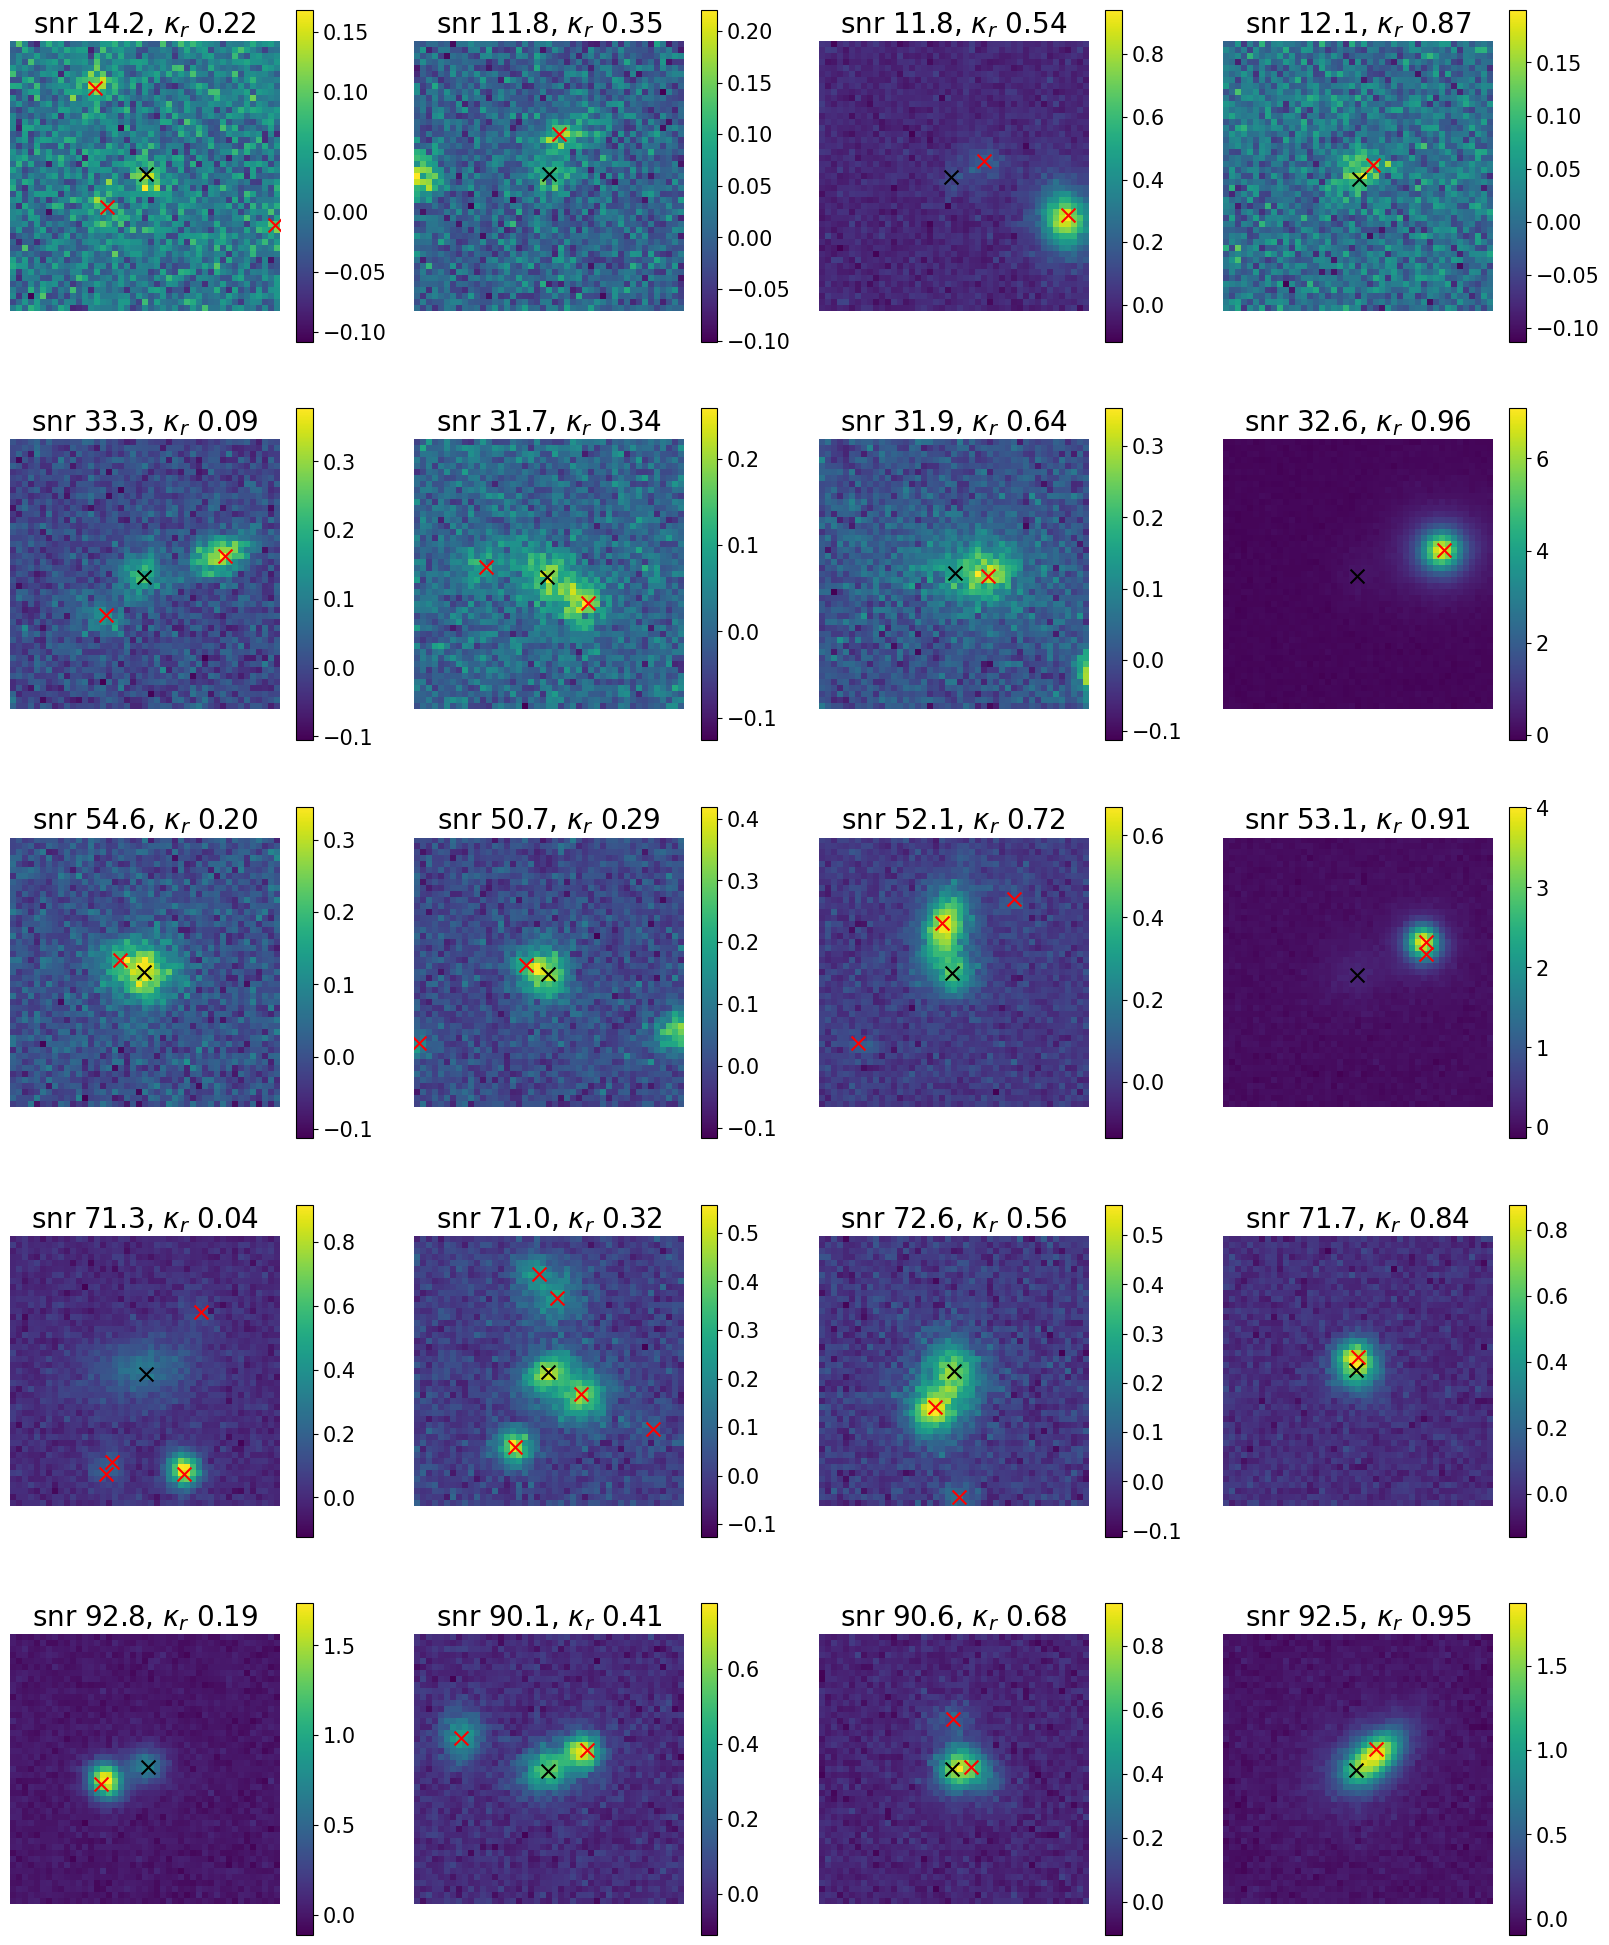

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(4 * 5, 5 * 5))
for snr_num, snr in enumerate(range(10, 110, 20)):
    # print(snr)
    mask = (madness_results["r_band_snr"] > snr) & (
        madness_results["r_band_snr"] < (snr + 5)
    )
    snr_cut = madness_results[mask]
    for contamination_num, contamination in enumerate(np.arange(0.01, 1.01, 0.25)):
        # print(contamination)
        mask2 = (snr_cut["r_contamination"] > contamination) & (
            snr_cut["r_contamination"] < (contamination + 0.25)
        )
        contamination_cut = snr_cut[mask2]

        row = contamination_cut.sample(random_state=21)

        file_num = row["file_num"].values[0]
        field_num = row["field_num"].values[0]
        galaxy_num = row["galaxy_num"].values[0]

        # print(row['file_num'].values[0])
        blend = hickle.load(
            os.path.join(
                simulation_path,
                str(file_num) + ".hkl",
            )
        )

        x_pos = blend["blend_list"][field_num]["y_peak"][galaxy_num]
        y_pos = blend["blend_list"][field_num]["x_peak"][galaxy_num]

        gal_blended = extract_cutouts(
            blend["blend_images"][field_num],
            [(x_pos, y_pos)],
            distances_to_center=False,
            channel_last=False,
            cutout_size=45,
        )[0][0]

        # print(np.shape(gal_enended))

        im1 = ax[snr_num, contamination_num].imshow(gal_blended[:, :, 2] / 10000)
        cbar = fig.colorbar(im1, ax=ax[snr_num, contamination_num])
        cbar.ax.tick_params(labelsize=15)
        ax[snr_num, contamination_num].set_title(
            r"snr {:.1f}, $\kappa_r$ {:.2f}".format(
                row["r_band_snr"].values[0], row["r_contamination"].values[0]
            ),
            fontsize=20,
        )
        # ax[snr_num, contamination_num].scatter(22, 22, c="r", marker="x")
        ax[snr_num, contamination_num].axis("off")
        for current_galaxy in range(len(blend["blend_list"][field_num]["x_peak"])):

            if current_galaxy == galaxy_num:
                continue

            y_loc = (
                np.round(blend["blend_list"][field_num]["y_peak"][current_galaxy])
                + 22
                - x_pos
            )
            x_loc = (
                np.round(blend["blend_list"][field_num]["x_peak"][current_galaxy])
                + 22
                - y_pos
            )

            if ((x_loc > 0) & (x_loc < 44)) & ((y_loc > 0) & (y_loc < 44)):

                ax[snr_num, contamination_num].scatter(
                    x_loc, y_loc, c="r", marker="x", s=100
                )

        # print(contamination_cut)
        ax[snr_num, contamination_num].scatter(
            np.round(blend["blend_list"][field_num]["y_peak"][galaxy_num]) + 22 - x_pos,
            np.round(blend["blend_list"][field_num]["x_peak"][galaxy_num]) + 22 - y_pos,
            c="black",
            marker="x",
            s=100,
        )

plt.savefig("results/contamination_variation_plot.pdf")
plt.savefig("results/contamination_variation_plot.png")